In [9]:
import json
import librosa
from essentia.standard import MonoLoader, TensorflowPredictMusiCNN, TensorflowPredictVGGish, SBic
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from importlib import reload


audio_path = 'assets/ambienceTrack_001(1).mp3'
# audio_path = 'assets/immersiveTrack_249.mp3'

In [2]:
y, sr = librosa.load(audio_path, sr=16000)
y.shape, y.shape[0] / sr

((14528906,), 908.056625)

In [36]:
import src.music.mir
reload(src.music.mir)
from src.music.mir import MIR


mir = MIR(weights_path='mir_weights/', distance_threshold=0.1)

[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mir_weights//discogs-effnet-bs64-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mir_weights//mtg_jamendo_genre-discogs-effnet-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mir_weights//mtg_jamendo_instrument-discogs-effnet-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mir_weights//msd-musicnn-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mir_weights//emomusic-msd-musicnn-2.pb`


In [37]:
res = mir.recognize_file(audio_path)

  0%|                                                    | 0/30 [00:00<?, ?it/s][   INFO   ] TensorflowPredict: Successfully loaded graph file: `mir_weights//mtg_jamendo_genre-discogs-effnet-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mir_weights//mtg_jamendo_instrument-discogs-effnet-1.pb`
100%|███████████████████████████████████████████| 30/30 [00:26<00:00,  1.13it/s]


### Key/Scale

In [5]:
res['key']

'D-major'

## Segments

8


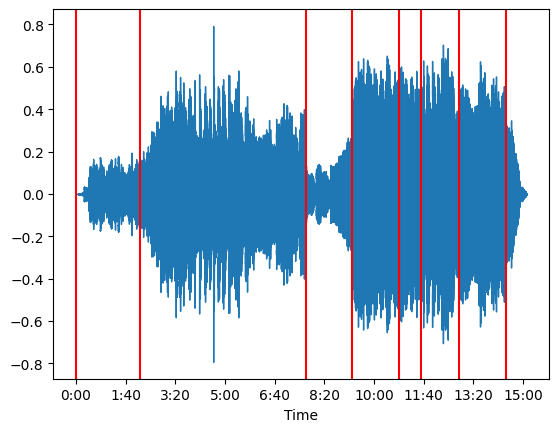

In [7]:
print(len(res['segments']))
librosa.display.waveshow(y, sr=sr, axis='time')
for b in res['segments']:
    plt.axvline(x=b, color='red')
plt.show()

### Genre

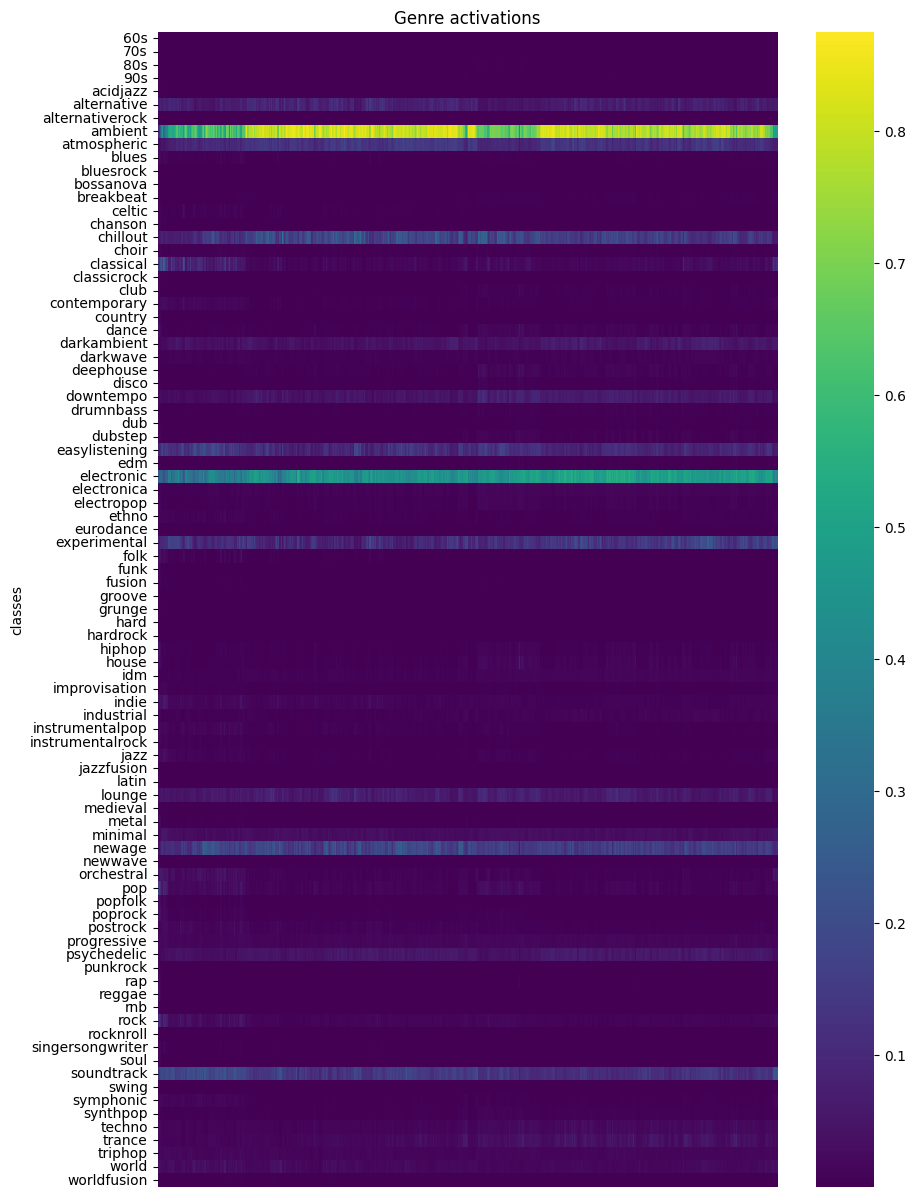

In [16]:
plt.figure(figsize=(10, 15))
ax = sns.heatmap(
    res['genre'].T, annot=False, cmap='viridis', cbar=True, yticklabels=mir.genre_classes, xticklabels=False
)
ax.set_ylabel('classes')
ax.set_title('Genre activations')

# Move x-axis to bottom
ax.xaxis.tick_bottom()

plt.show()

### Instrumentation

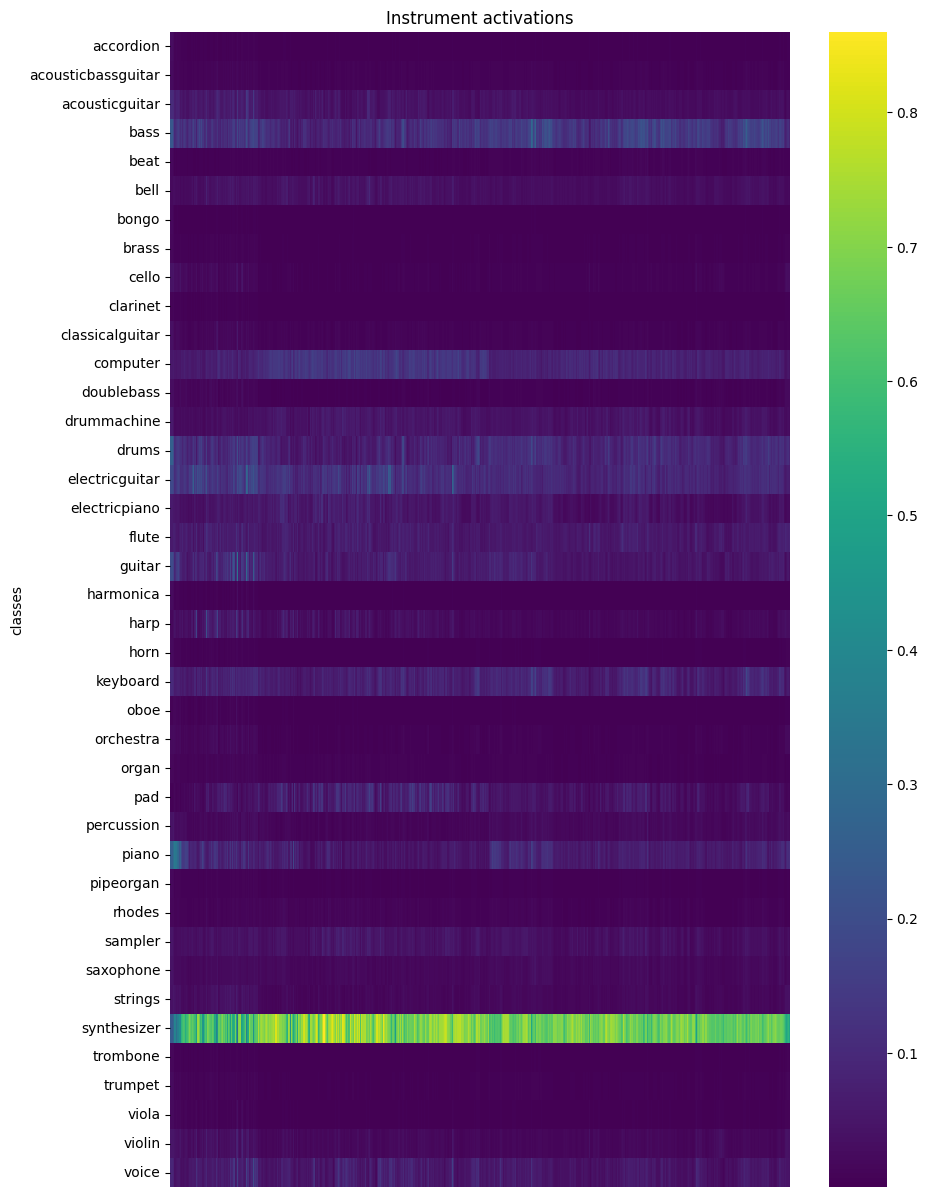

In [38]:
plt.figure(figsize=(10, 15))
ax = sns.heatmap(
    res['instrument'].T, annot=False, cmap='viridis', cbar=True, yticklabels=mir.inst_classes, xticklabels=False
)
ax.set_ylabel('classes')
ax.set_title('Instrument activations')

# Move x-axis to bottom
ax.xaxis.tick_bottom()

plt.show()

### Emotion Recognition

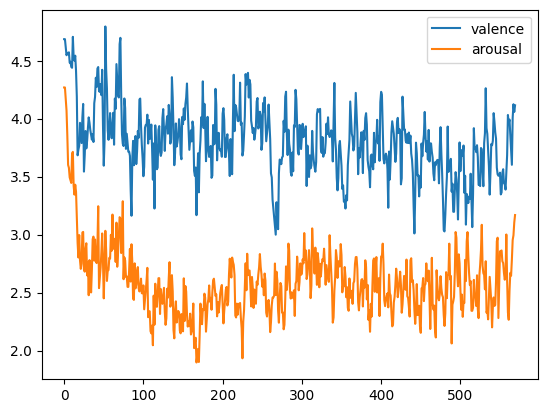

In [18]:
plt.plot(res['emotion'][:, 0], label='valence')
plt.plot(res['emotion'][:, 1], label='arousal')
plt.legend()

In [21]:
res['instrument'].shape

(870, 40)

### Beat / Tempo

In [22]:
res['tempo']

119.0

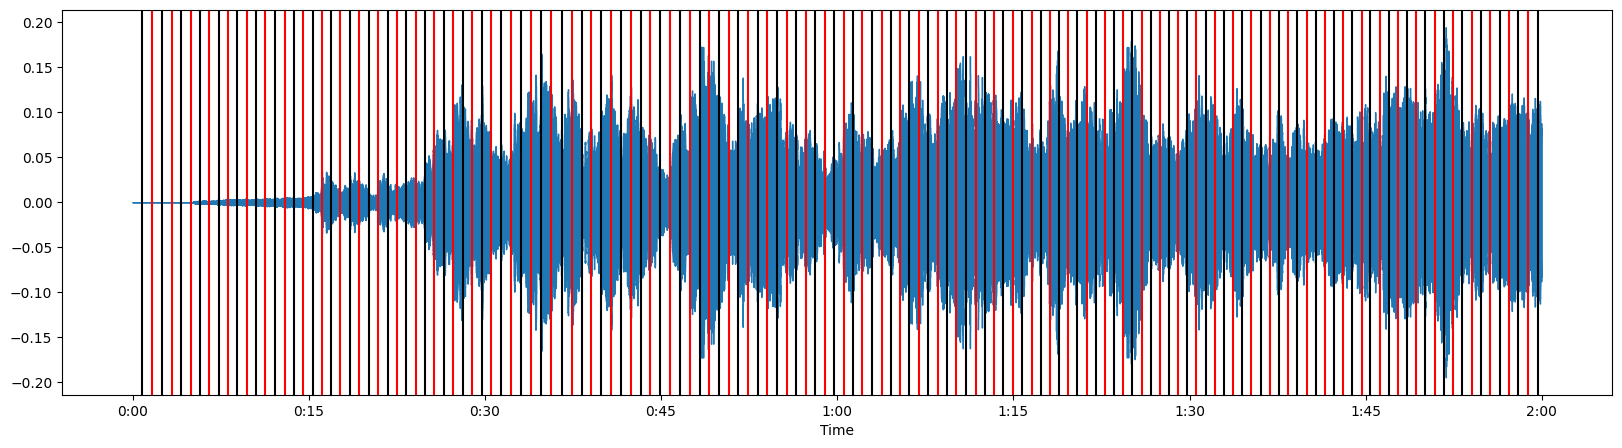

In [23]:
plt.figure(figsize=(20, 5))
s = 0 * 60 
e = 2 * 60
librosa.display.waveshow(y[s * sr: e * sr], sr=sr)
beats = res['beats'][:, 0]
is_downbeat = res['beats'][:, 1]
mask = (beats > s) & (beats < e)

for beat, is_db in zip(beats[mask], is_downbeat[mask]):
    if is_db == 1:
        plt.axvline(x=beat-s, color='red')
    else:
        plt.axvline(x=beat-s, color='black')